This notebook supports the Linguistic Binding paper:
https://arxiv.org/abs/2306.08877

and repo:
https://github.com/RoyiRa/Syntax-Guided-Generation

In [1]:
!pip install diffusers==0.21.1
!pip install numpy==1.23.5
!pip install spacy==3.6.1
!pip install tqdm==4.65.0
!pip install transformers==4.30.2
!pip install torch==2.0.1
!pip install accelerate==0.23.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.21.1-py3-none-any.whl size=1486515 sha256=9308224ab97790e94542dc772ec7a6f7a9b455abe56d7777fbac6e58cccb008a
  Stored in directory: /root/.cache/pip/wheels/a8/52/ec/901d7f3e1128bc56ea4365e9d3a157c1088e5450f4e8f7b202
Successfully built diffusers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 1.6 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.3 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.0
    Uninstalling to

# Install spaCy parser

In [2]:
!python -m spacy download en_core_web_trf

2023-12-27 08:53:47.184803: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-27 08:53:47.238227: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-27 08:53:47.238272: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-27 08:53:47.240218: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-27 08:53:47.248820: I tensorflow/core/platform/cpu_feature_guar

# Computing the loss

In [3]:
import torch.distributions as dist
from typing import List, Dict
import itertools

start_token = "<|startoftext|>"
end_token = "<|endoftext|>"


def _get_outside_indices(subtree_indices, attn_map_idx_to_wp):
    flattened_subtree_indices = _flatten_indices(subtree_indices)
    outside_indices = [
        map_idx
        for map_idx in attn_map_idx_to_wp.keys() if (map_idx not in flattened_subtree_indices)
    ]
    return outside_indices


def _flatten_indices(related_indices):
    flattened_related_indices = []
    for item in related_indices:
        if isinstance(item, list):
            flattened_related_indices.extend(item)
        else:
            flattened_related_indices.append(item)
    return flattened_related_indices


def split_indices(related_indices: List[int]):
    noun = [related_indices[-1]]  # assumes noun is always last in the list
    modifier = related_indices[:-1]
    if isinstance(modifier, int):
        modifier = [modifier]
    return noun, modifier


def _symmetric_kl(attention_map1, attention_map2):
    # Convert map into a single distribution: 16x16 -> 256
    if len(attention_map1.shape) > 1:
        attention_map1 = attention_map1.reshape(-1)
    if len(attention_map2.shape) > 1:
        attention_map2 = attention_map2.reshape(-1)

    p = dist.Categorical(probs=attention_map1)
    q = dist.Categorical(probs=attention_map2)

    kl_divergence_pq = dist.kl_divergence(p, q)
    kl_divergence_qp = dist.kl_divergence(q, p)

    avg_kl_divergence = (kl_divergence_pq + kl_divergence_qp) / 2
    return avg_kl_divergence


def calculate_positive_loss(attention_maps, modifier, noun):
    src_indices = modifier
    dest_indices = noun

    if isinstance(src_indices, list) and isinstance(dest_indices, list):
        wp_pos_loss = [
            _symmetric_kl(attention_maps[s], attention_maps[d])
            for (s, d) in itertools.product(src_indices, dest_indices)
        ]
        positive_loss = max(wp_pos_loss)
    elif isinstance(dest_indices, list):
        wp_pos_loss = [
            _symmetric_kl(attention_maps[src_indices], attention_maps[d])
            for d in dest_indices
        ]
        positive_loss = max(wp_pos_loss)
    elif isinstance(src_indices, list):
        wp_pos_loss = [
            _symmetric_kl(attention_maps[s], attention_maps[dest_indices])
            for s in src_indices
        ]
        positive_loss = max(wp_pos_loss)
    else:
        positive_loss = _symmetric_kl(
            attention_maps[src_indices], attention_maps[dest_indices]
        )

    return positive_loss


def _calculate_outside_loss(attention_maps, src_indices, outside_loss):
    negative_loss = []
    computed_pairs = set()
    pair_counter = 0

    for outside_idx in outside_loss:
        if isinstance(src_indices, list):
            wp_neg_loss = []
            for t in src_indices:
                pair_key = (t, outside_idx)
                if pair_key not in computed_pairs:
                    wp_neg_loss.append(
                        _symmetric_kl(
                            attention_maps[t], attention_maps[outside_idx]
                        )
                    )
                    computed_pairs.add(pair_key)
            negative_loss.append(max(wp_neg_loss) if wp_neg_loss else 0)
            pair_counter += 1

        else:
            pair_key = (src_indices, outside_idx)
            if pair_key not in computed_pairs:
                negative_loss.append(
                    _symmetric_kl(
                        attention_maps[src_indices], attention_maps[outside_idx]
                    )
                )
                computed_pairs.add(pair_key)
                pair_counter += 1

    return negative_loss, pair_counter


def align_wordpieces_indices(
        wordpieces2indices, start_idx, target_word
):
    """
    Aligns a `target_word` that contains more than one wordpiece (the first wordpiece is `start_idx`)
    """

    wp_indices = [start_idx]
    wp = wordpieces2indices[start_idx].replace("</w>", "")

    # Run over the next wordpieces in the sequence (which is why we use +1)
    for wp_idx in range(start_idx + 1, len(wordpieces2indices)):
        if wp.lower() == target_word.lower():
            break

        wp2 = wordpieces2indices[wp_idx].replace("</w>", "")
        if target_word.lower().startswith(wp.lower() + wp2.lower()) and wp2.lower() != target_word.lower():
            wp += wordpieces2indices[wp_idx].replace("</w>", "")
            wp_indices.append(wp_idx)
        else:
            wp_indices = (
                []
            )  # if there's no match, you want to clear the list and finish
            break

    return wp_indices


def extract_attribution_indices(doc):
    # doc = parser(prompt)
    subtrees = []
    modifiers = ["amod", "nmod", "compound", "npadvmod", "advmod", "acomp"]

    for w in doc:
        if w.pos_ not in ["NOUN", "PROPN"] or w.dep_ in modifiers:
            continue
        subtree = []
        stack = []
        for child in w.children:
            if child.dep_ in modifiers:
                subtree.append(child)
                stack.extend(child.children)

        while stack:
            node = stack.pop()
            if node.dep_ in modifiers or node.dep_ == "conj":
                subtree.append(node)
                stack.extend(node.children)
        if subtree:
            subtree.append(w)
            subtrees.append(subtree)
    return subtrees

def extract_attribution_indices_with_verbs(doc):
    '''This function specifically addresses cases where a verb is between
       a noun and its modifier. For instance: "a dog that is red"
       here, the aux is between 'dog' and 'red'. '''

    subtrees = []
    modifiers = ["amod", "nmod", "compound", "npadvmod", "advmod", "acomp",
                 'relcl']
    for w in doc:
        if w.pos_ not in ["NOUN", "PROPN"] or w.dep_ in modifiers:
            continue
        subtree = []
        stack = []
        for child in w.children:
            if child.dep_ in modifiers:
                if child.pos_ not in ['AUX', 'VERB']:
                    subtree.append(child)
                stack.extend(child.children)

        while stack:
            node = stack.pop()
            if node.dep_ in modifiers or node.dep_ == "conj":
                # we don't want to add 'is' or other verbs to the loss, we want their children
                if node.pos_ not in ['AUX', 'VERB']:
                    subtree.append(node)
                stack.extend(node.children)
        if subtree:
            subtree.append(w)
            subtrees.append(subtree)
        return subtrees

def extract_attribution_indices_with_verb_root(doc):
    '''This function specifically addresses cases where a verb is between
       a noun and its modifier. For instance: "a dog that is red"
       here, the aux is between 'dog' and 'red'. '''

    subtrees = []
    modifiers = ["amod", "nmod", "compound", "npadvmod", "advmod", "acomp"]

    for w in doc:
        subtree = []
        stack = []

        # if w is a verb/aux and has a noun child and a modifier child, add them to the stack
        if w.pos_ != 'AUX' or w.dep_ in modifiers:
            continue

        for child in w.children:
            if child.dep_ in modifiers or child.pos_ in ['NOUN', 'PROPN']:
                if child.pos_ not in ['AUX', 'VERB']:
                    subtree.append(child)
                stack.extend(child.children)
        # did not find a pair of noun and modifier
        if len(subtree) < 2:
            continue

        while stack:
            node = stack.pop()
            if node.dep_ in modifiers or node.dep_ == "conj":
                # we don't want to add 'is' or other verbs to the loss, we want their children
                if node.pos_ not in ['AUX']:
                    subtree.append(node)
                stack.extend(node.children)

        if subtree:
            if w.pos_ not in ['AUX']:
                subtree.append(w)
            subtrees.append(subtree)
    return subtrees


def extract_entities_only(doc):
    entities = []
    for w in doc:
        if w.pos_ in ['NOUN', 'PROPN']:
            entities.append([w])
    return entities


def calculate_negative_loss(
        attention_maps, modifier, noun, subtree_indices, attn_map_idx_to_wp
):
    outside_indices = _get_outside_indices(subtree_indices, attn_map_idx_to_wp)

    negative_noun_loss, num_noun_pairs = _calculate_outside_loss(
        attention_maps, noun, outside_indices
    )
    if outside_indices:
      negative_noun_loss = -sum(negative_noun_loss) / len(outside_indices)
    else:
      negative_noun_loss = 0

    if modifier:
        negative_modifier_loss, num_modifier_pairs = _calculate_outside_loss(
            attention_maps, modifier, outside_indices
        )
        if outside_indices:
          negative_modifier_loss = -sum(negative_modifier_loss) / len(outside_indices)
        else:
          negative_modifier_loss = 0

        negative_loss = (negative_modifier_loss + negative_noun_loss) / 2
    else:
        negative_loss = negative_noun_loss

    return negative_loss


def get_indices(tokenizer, prompt: str) -> Dict[str, int]:
    """Utility function to list the indices of the tokens you wish to alter"""
    ids = tokenizer(prompt).input_ids
    indices = {
        i: tok
        for tok, i in zip(
            tokenizer.convert_ids_to_tokens(ids), range(len(ids))
        )
    }
    return indices

def get_attention_map_index_to_wordpiece(tokenizer, prompt):
    attn_map_idx_to_wp = {}

    wordpieces2indices = get_indices(tokenizer, prompt)

    # Ignore `start_token` and `end_token`
    for i in list(wordpieces2indices.keys())[1:-1]:
        wordpiece = wordpieces2indices[i]
        wordpiece = wordpiece.replace("</w>", "")
        attn_map_idx_to_wp[i] = wordpiece

    return attn_map_idx_to_wp

# SynGen Pipeline

In [4]:
import itertools
from typing import Any, Callable, Dict, Optional, Union, List

import spacy
import torch
from diffusers import StableDiffusionPipeline, AutoencoderKL, UNet2DConditionModel
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput, StableDiffusionSafetyChecker
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion import (
    EXAMPLE_DOC_STRING,
    rescale_noise_cfg
)
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_attend_and_excite import (
    AttentionStore,
    AttendExciteAttnProcessor
)
import numpy as np
from diffusers.schedulers import KarrasDiffusionSchedulers
from diffusers.utils import (
    logging,
    replace_example_docstring,
)
from transformers import CLIPImageProcessor, CLIPTextModel, CLIPTokenizer


logger = logging.get_logger(__name__)


class SynGenDiffusionPipeline(StableDiffusionPipeline):
    def __init__(self,
                 vae: AutoencoderKL,
                 text_encoder: CLIPTextModel,
                 tokenizer: CLIPTokenizer,
                 unet: UNet2DConditionModel,
                 scheduler: KarrasDiffusionSchedulers,
                 safety_checker: StableDiffusionSafetyChecker,
                 feature_extractor: CLIPImageProcessor,
                 requires_safety_checker: bool = True,
                 include_entities: bool = False,
                 ):
        super().__init__(vae, text_encoder, tokenizer, unet, scheduler, safety_checker, feature_extractor,
                         requires_safety_checker)

        self.parser = spacy.load("en_core_web_trf")
        self.subtrees_indices = None
        self.doc = None
        self.include_entities = include_entities

    def _aggregate_and_get_attention_maps_per_token(self):
        attention_maps = self.attention_store.aggregate_attention(
            from_where=("up", "down", "mid"),
        )
        attention_maps_list = _get_attention_maps_list(
            attention_maps=attention_maps
        )
        return attention_maps_list

    @staticmethod
    def _update_latent(
            latents: torch.Tensor, loss: torch.Tensor, step_size: float
    ) -> torch.Tensor:
        """Update the latent according to the computed loss."""
        grad_cond = torch.autograd.grad(
            loss.requires_grad_(True), [latents], retain_graph=True
        )[0]
        latents = latents - step_size * grad_cond
        return latents

    def register_attention_control(self):
        attn_procs = {}
        cross_att_count = 0
        for name in self.unet.attn_processors.keys():
            if name.startswith("mid_block"):
                place_in_unet = "mid"
            elif name.startswith("up_blocks"):
                place_in_unet = "up"
            elif name.startswith("down_blocks"):
                place_in_unet = "down"
            else:
                continue

            cross_att_count += 1
            attn_procs[name] = AttendExciteAttnProcessor(
                attnstore=self.attention_store, place_in_unet=place_in_unet
            )

        self.unet.set_attn_processor(attn_procs)
        self.attention_store.num_att_layers = cross_att_count

    @torch.no_grad()
    @replace_example_docstring(EXAMPLE_DOC_STRING)
    def __call__(
            self,
            prompt: Union[str, List[str]] = None,
            height: Optional[int] = None,
            width: Optional[int] = None,
            num_inference_steps: int = 50,
            guidance_scale: float = 7.5,
            negative_prompt: Optional[Union[str, List[str]]] = None,
            num_images_per_prompt: Optional[int] = 1,
            eta: float = 0.0,
            generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
            latents: Optional[torch.FloatTensor] = None,
            prompt_embeds: Optional[torch.FloatTensor] = None,
            negative_prompt_embeds: Optional[torch.FloatTensor] = None,
            output_type: Optional[str] = "pil",
            return_dict: bool = True,
            callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
            callback_steps: int = 1,
            cross_attention_kwargs: Optional[Dict[str, Any]] = None,
            guidance_rescale: float = 0.0,
            attn_res=None,
            syngen_step_size: float = 20.0,
            parsed_prompt: str = None,
            num_intervention_steps: int = 25,
    ):
        r"""
        The call function to the pipeline for generation.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts to guide image generation. If not defined, you need to pass `prompt_embeds`.
            height (`int`, *optional*, defaults to `self.unet.config.sample_size * self.vae_scale_factor`):
                The height in pixels of the generated image.
            width (`int`, *optional*, defaults to `self.unet.config.sample_size * self.vae_scale_factor`):
                The width in pixels of the generated image.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            guidance_scale (`float`, *optional*, defaults to 7.5):
                A higher guidance scale value encourages the model to generate images closely linked to the text
                `prompt` at the expense of lower image quality. Guidance scale is enabled when `guidance_scale > 1`.
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts to guide what to not include in image generation. If not defined, you need to
                pass `negative_prompt_embeds` instead. Ignored when not using guidance (`guidance_scale < 1`).
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                The number of images to generate per prompt.
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) from the [DDIM](https://arxiv.org/abs/2010.02502) paper. Only applies
                to the [`~schedulers.DDIMScheduler`], and is ignored in other schedulers.
            generator (`torch.Generator` or `List[torch.Generator]`, *optional*):
                A [`torch.Generator`](https://pytorch.org/docs/stable/generated/torch.Generator.html) to make
                generation deterministic.
            latents (`torch.FloatTensor`, *optional*):
                Pre-generated noisy latents sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor is generated by sampling using the supplied random `generator`.
            prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs (prompt weighting). If not
                provided, text embeddings are generated from the `prompt` input argument.
            negative_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated negative text embeddings. Can be used to easily tweak text inputs (prompt weighting). If
                not provided, `negative_prompt_embeds` are generated from the `negative_prompt` input argument.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generated image. Choose between `PIL.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] instead of a
                plain tuple.
            callback (`Callable`, *optional*):
                A function that calls every `callback_steps` steps during inference. The function is called with the
                following arguments: `callback(step: int, timestep: int, latents: torch.FloatTensor)`.
            callback_steps (`int`, *optional*, defaults to 1):
                The frequency at which the `callback` function is called. If not specified, the callback is called at
                every step.
            cross_attention_kwargs (`dict`, *optional*):
                A kwargs dictionary that if specified is passed along to the [`AttentionProcessor`] as defined in
                [`self.processor`](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/attention_processor.py).
            guidance_rescale (`float`, *optional*, defaults to 0.7):
                Guidance rescale factor from [Common Diffusion Noise Schedules and Sample Steps are
                Flawed](https://arxiv.org/pdf/2305.08891.pdf). Guidance rescale factor should fix overexposure when
                using zero terminal SNR.
            attn_res (`tuple`, *optional*, default computed from width and height):
                The 2D resolution of the semantic attention map.
            syngen_step_size (`float`, *optional*, default to 20.0):
                Controls the step size of each SynGen update.
            num_intervention_steps ('int', *optional*, defaults to 25):
                The number of times we apply SynGen.
            parsed_prompt (`str`, *optional*, default to None).


        Examples:

        Returns:
            [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] or `tuple`:
                If `return_dict` is `True`, [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] is returned,
                otherwise a `tuple` is returned where the first element is a list with the generated images and the
                second element is a list of `bool`s indicating whether the corresponding generated image contains
                "not-safe-for-work" (nsfw) content.
        """

        if parsed_prompt:
            self.doc = parsed_prompt
        else:
            self.doc = self.parser(prompt)
        # 0. Default height and width to unet
        height = height or self.unet.config.sample_size * self.vae_scale_factor
        width = width or self.unet.config.sample_size * self.vae_scale_factor

        # 1. Check inputs. Raise error if not correct
        self.check_inputs(
            prompt,
            height,
            width,
            callback_steps,
            negative_prompt,
            prompt_embeds,
            negative_prompt_embeds,
        )

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0

        # 3. Encode input prompt
        text_encoder_lora_scale = (
            cross_attention_kwargs.get("scale", None) if cross_attention_kwargs is not None else None
        )
        prompt_embeds, negative_prompt_embeds = self.encode_prompt(
            prompt,
            device,
            num_images_per_prompt,
            do_classifier_free_guidance,
            negative_prompt,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            lora_scale=text_encoder_lora_scale,
        )
        # For classifier free guidance, we need to do two forward passes.
        # Here we concatenate the unconditional and text embeddings into a single batch
        # to avoid doing two forward passes
        if do_classifier_free_guidance:
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

        # 4. Prepare timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps = self.scheduler.timesteps

        # 5. Prepare latent variables
        num_channels_latents = self.unet.config.in_channels
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )

        # 6. Prepare extra step kwargs.
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        if attn_res is None:
            attn_res = int(np.ceil(width / 32)), int(np.ceil(height / 32))
        self.attn_res = attn_res
        self.attention_store = AttentionStore(self.attn_res)
        self.register_attention_control()

        text_embeddings = (
            prompt_embeds[batch_size * num_images_per_prompt:] if do_classifier_free_guidance else prompt_embeds
        )

        # 7. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                if i < num_intervention_steps:
                    latents = self._syngen_step(
                        latents,
                        text_embeddings,
                        t,
                        i,
                        syngen_step_size,
                        cross_attention_kwargs,
                        prompt,
                        num_intervention_steps=num_intervention_steps,
                    )

                # expand the latents if we are doing classifier free guidance
                latent_model_input = (
                    torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                )
                latent_model_input = self.scheduler.scale_model_input(
                    latent_model_input, t
                )

                # predict the noise residual
                noise_pred = self.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=prompt_embeds,
                    cross_attention_kwargs=cross_attention_kwargs,
                    return_dict=False,
                )[0]

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (
                            noise_pred_text - noise_pred_uncond
                    )

                if do_classifier_free_guidance and guidance_rescale > 0.0:
                    # Based on 3.4. in https://arxiv.org/pdf/2305.08891.pdf
                    noise_pred = rescale_noise_cfg(noise_pred, noise_pred_text, guidance_rescale=guidance_rescale)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]

                # call the callback, if provided
                if i == len(timesteps) - 1 or (
                        (i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0
                ):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        callback(i, t, latents)

        if not output_type == "latent":
            image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False)[0]
            image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)
        else:
            image = latents
            has_nsfw_concept = None

        if has_nsfw_concept is None:
            do_denormalize = [True] * image.shape[0]
        else:
            do_denormalize = [not has_nsfw for has_nsfw in has_nsfw_concept]

        image = self.image_processor.postprocess(image, output_type=output_type, do_denormalize=do_denormalize)

        # Offload all models
        self.maybe_free_model_hooks()

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(
            images=image, nsfw_content_detected=has_nsfw_concept
        )

    def _syngen_step(
            self,
            latents,
            text_embeddings,
            t,
            i,
            step_size,
            cross_attention_kwargs,
            prompt,
            num_intervention_steps,
    ):
        with torch.enable_grad():
            latents = latents.clone().detach().requires_grad_(True)
            updated_latents = []
            for latent, text_embedding in zip(latents, text_embeddings):
                # Forward pass of denoising with text conditioning
                latent = latent.unsqueeze(0)
                text_embedding = text_embedding.unsqueeze(0)

                self.unet(
                    latent,
                    t,
                    encoder_hidden_states=text_embedding,
                    cross_attention_kwargs=cross_attention_kwargs,
                    return_dict=False,
                )[0]
                self.unet.zero_grad()
                # Get attention maps
                attention_maps = self._aggregate_and_get_attention_maps_per_token()
                loss = self._compute_loss(attention_maps=attention_maps, prompt=prompt)
                # Perform gradient update
                if i < num_intervention_steps:
                    if loss != 0:
                        latent = self._update_latent(
                            latents=latent, loss=loss, step_size=step_size
                        )
                    logger.info(f"Iteration {i} | Loss: {loss:0.4f}")

            updated_latents.append(latent)

        latents = torch.cat(updated_latents, dim=0)

        return latents

    def _compute_loss(
            self, attention_maps: List[torch.Tensor], prompt: Union[str, List[str]]
    ) -> torch.Tensor:
        attn_map_idx_to_wp = get_attention_map_index_to_wordpiece(self.tokenizer, prompt)
        loss = self._attribution_loss(attention_maps, prompt, attn_map_idx_to_wp)

        return loss

    def _attribution_loss(
            self,
            attention_maps: List[torch.Tensor],
            prompt: Union[str, List[str]],
            attn_map_idx_to_wp,
    ) -> torch.Tensor:
        if not self.subtrees_indices:
            self.subtrees_indices = self._extract_attribution_indices(prompt)
        subtrees_indices = self.subtrees_indices

        loss = 0

        for subtree_indices in subtrees_indices:
            noun, modifier = split_indices(subtree_indices)
            all_subtree_pairs = list(itertools.product(noun, modifier))
            if noun and not modifier:
                if isinstance(noun, list) and len(noun) == 1:
                    processed_noun = noun[0]
                else:
                    processed_noun = noun
                loss += calculate_negative_loss(
                        attention_maps, modifier, processed_noun, subtree_indices, attn_map_idx_to_wp
                    )
            else:
                positive_loss, negative_loss = self._calculate_losses(
                    attention_maps,
                    all_subtree_pairs,
                    subtree_indices,
                    attn_map_idx_to_wp,
                )

                loss += positive_loss
                loss += negative_loss

        return loss

    def _calculate_losses(
            self,
            attention_maps,
            all_subtree_pairs,
            subtree_indices,
            attn_map_idx_to_wp,
    ):
        positive_loss = []
        negative_loss = []
        for pair in all_subtree_pairs:
            noun, modifier = pair
            positive_loss.append(
                calculate_positive_loss(attention_maps, modifier, noun)
            )
            negative_loss.append(
                calculate_negative_loss(
                    attention_maps, modifier, noun, subtree_indices, attn_map_idx_to_wp
                )
            )

        positive_loss = sum(positive_loss)
        negative_loss = sum(negative_loss)

        return positive_loss, negative_loss

    def _align_indices(self, prompt, spacy_pairs):
        wordpieces2indices = get_indices(self.tokenizer, prompt)
        paired_indices = []
        collected_spacy_indices = (
            set()
        )  # helps track recurring nouns across different relations (i.e., cases where there is more than one instance of the same word)

        for pair in spacy_pairs:
            curr_collected_wp_indices = (
                []
            )  # helps track which nouns and amods were added to the current pair (this is useful in sentences with repeating amod on the same relation (e.g., "a red red red bear"))
            for member in pair:
                for idx, wp in wordpieces2indices.items():
                    if wp in [start_token, end_token]:
                        continue

                    wp = wp.replace("</w>", "")
                    if member.text.lower() == wp.lower():
                        if idx not in curr_collected_wp_indices and idx not in collected_spacy_indices:
                            curr_collected_wp_indices.append(idx)
                            break
                    # take care of wordpieces that are split up
                    elif member.text.lower().startswith(wp.lower()) and wp.lower() != member.text.lower():  # can maybe be while loop
                        wp_indices = align_wordpieces_indices(
                            wordpieces2indices, idx, member.text
                        )
                        # check if all wp_indices are not already in collected_spacy_indices
                        if wp_indices and (wp_indices not in curr_collected_wp_indices) and all(
                                [wp_idx not in collected_spacy_indices for wp_idx in wp_indices]):
                            curr_collected_wp_indices.append(wp_indices)
                            break

            for collected_idx in curr_collected_wp_indices:
                if isinstance(collected_idx, list):
                    for idx in collected_idx:
                        collected_spacy_indices.add(idx)
                else:
                    collected_spacy_indices.add(collected_idx)

            if curr_collected_wp_indices:
                paired_indices.append(curr_collected_wp_indices)
            else:
                print(f"No wordpieces were aligned for {pair} in _align_indices")

        return paired_indices

    def _extract_attribution_indices(self, prompt):
        modifier_indices = []
        # extract standard attribution indices
        modifier_sets_1 = extract_attribution_indices(self.doc)
        modifier_indices_1 = self._align_indices(prompt, modifier_sets_1)
        if modifier_indices_1:
            modifier_indices.append(modifier_indices_1)

        # extract attribution indices with verbs in between
        modifier_sets_2 = extract_attribution_indices_with_verb_root(self.doc)
        modifier_indices_2 = self._align_indices(prompt, modifier_sets_2)
        if modifier_indices_2:
            modifier_indices.append(modifier_indices_2)

        modifier_sets_3 = extract_attribution_indices_with_verbs(self.doc)
        modifier_indices_3 = self._align_indices(prompt, modifier_sets_3)
        if modifier_indices_3:
            modifier_indices.append(modifier_indices_3)

        # entities only
        if self.include_entities:
            modifier_sets_4 = extract_entities_only(self.doc)
            modifier_indices_4 = self._align_indices(prompt, modifier_sets_4)
            modifier_indices.append(modifier_indices_4)

        # make sure there are no duplicates
        modifier_indices = unify_lists(modifier_indices)

        return modifier_indices


def _get_attention_maps_list(
        attention_maps: torch.Tensor
) -> List[torch.Tensor]:
    attention_maps *= 100
    attention_maps_list = [
        attention_maps[:, :, i] for i in range(attention_maps.shape[2])
    ]

    return attention_maps_list


def unify_lists(list_of_lists):
    def flatten(lst):
        for elem in lst:
            if isinstance(elem, list):
                yield from flatten(elem)
            else:
                yield elem

    def have_common_element(lst1, lst2):
        flat_list1 = set(flatten(lst1))
        flat_list2 = set(flatten(lst2))
        return not flat_list1.isdisjoint(flat_list2)

    lst = []
    for l in list_of_lists:
        lst += l
    changed = True
    while changed:
        changed = False
        merged_list = []
        while lst:
            first = lst.pop(0)
            was_merged = False
            for index, other in enumerate(lst):
                if have_common_element(first, other):
                    # If we merge, we should flatten the other list but not first
                    new_merged = first + [item for item in other if item not in first]
                    lst[index] = new_merged
                    changed = True
                    was_merged = True
                    break
            if not was_merged:
                merged_list.append(first)
        lst = merged_list

    return lst

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

# Run

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

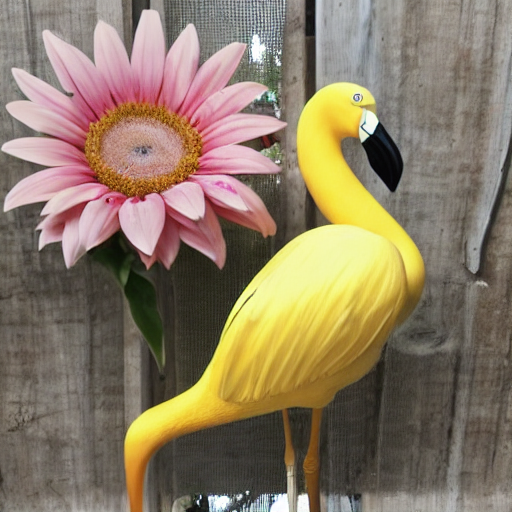

In [5]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
seed = 16
g_cpu = torch.Generator(device.type).manual_seed(seed)

pipe = SynGenDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", include_entities=False).to(device)

tokenizer = pipe.tokenizer

prompt = "A yellow flamingo and a pink sunflower"
image = pipe(prompt, generator=g_cpu, num_intervention_steps=25, attn_res=(16,16))
from IPython.display import display

for img in image['images']:
  display(img)